TP DE MACHINE LEARNING !!!

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('WineQT.csv')

<AxesSubplot:>

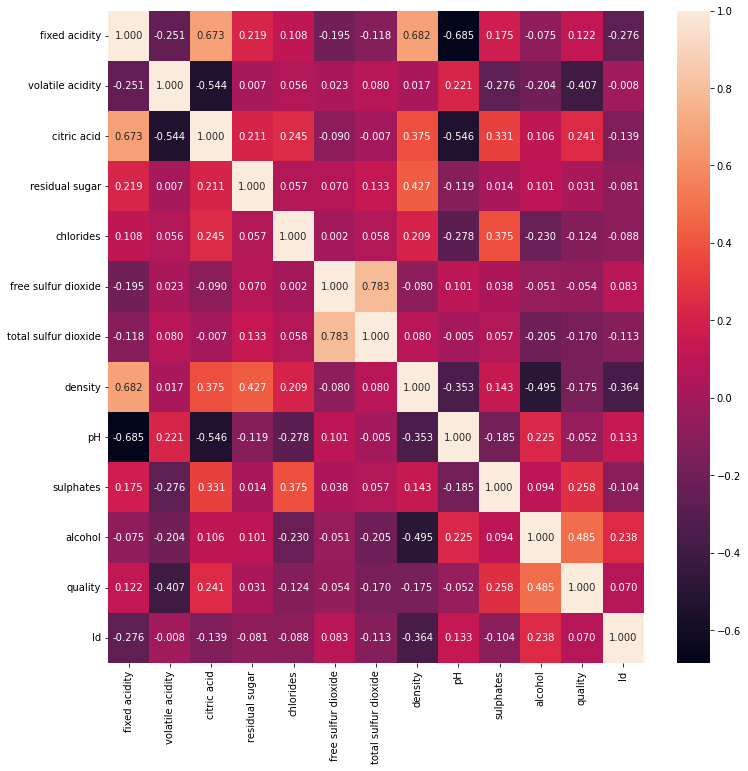

In [10]:
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.3f')

In [7]:
df['total sulfur dioxide'] = np.log(df['total sulfur dioxide'])
df['residual sugar'] = np.log(df['residual sugar'])
df['free sulfur dioxide'] = np.log(df['free sulfur dioxide'])


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(40, 30))
for n in range(12):
    i = n % 3
    j = n % 4
    ax[i, j].hist(df.iloc[:, n], bins='auto')
    ax[i, j].set_title(df.columns[n])

VOIR LES VARIABLES

[[0.7  9.4  0.56 0.  ]]
[5 5 5 ... 5 6 5]
1143
1143


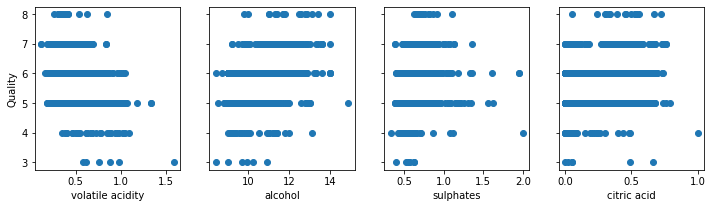

In [47]:
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)
print(X_train[:1])
print(y_train)
print(len(X_train))
print(len(y_train))
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_train[:,i]],[y_train])
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Quality")
plt.show()


NORMALISATION

In [50]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

# normalize the original features



In [51]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [[ 0.53133858 10.4421114   0.65770779  0.26836395]], 
X_sigma = [[0.1795546  1.0817221  0.17032416 0.19659979]]
Peak to Peak range by column in Raw        X:[[1.46 6.5  1.67 1.  ]]
Peak to Peak range by column in Normalized X:[[8.13123157 6.00893702 9.80483344 5.08647531]]


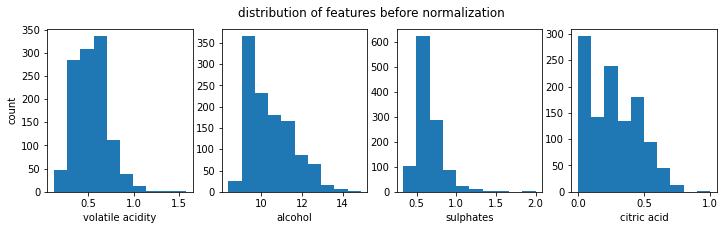

In [57]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    ax[i].hist(X_train[:,i])
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count")
fig.suptitle("distribution of features before normalization")
plt.show()